In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Task 1. csv 파일을 다운로드 받고 pandas를 이용하여 불러오기

In [ ]:
# Task 1-1. 데이터 불러오기

#data1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/데이터과학/data/owid-covid-data.csv")
data1 = pd.read_csv("./owid-covid-data.csv")

# Task 1-2.  'date'열의 데이터를 날짜 타입으로 변경하기

data1['date'] = pd.to_datetime(data1['date'])

data1

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127812,ZWE,Africa,Zimbabwe,2021-10-28,132880.0,72.0,48.571,4675.0,0.0,1.857,8804.565,4.771,3.218,309.763,0.000,0.123,0.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3966.0,1365439.0,90.473,0.263,3180.0,0.211,0.015,65.5,tests performed,5896902.0,3306845.0,2590057.0,NaN,14221.0,14231.0,39.07,21.91,17.16,NaN,943.0,44.44,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
127813,ZWE,Africa,Zimbabwe,2021-10-29,132926.0,46.0,48.286,4675.0,0.0,1.714,8807.613,3.048,3.199,309.763,0.000,0.114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2740.0,1368179.0,90.655,0.182,3018.0,0.200,0.016,62.5,tests performed,5914009.0,3315108.0,2598901.0,NaN,17107.0,14174.0,39.19,21.97,17.22,NaN,939.0,44.44,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,Na

# Task 2. 한국과 일본의 코로나 상황 비교 시각화하기

In [ ]:
data2 = data1[['date', 'location', 'total_cases_per_million', 'new_cases_per_million', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']]
korea = data2.loc[data1['location'] == 'South Korea']
japan = data2.loc[data1['location'] == 'Japan']

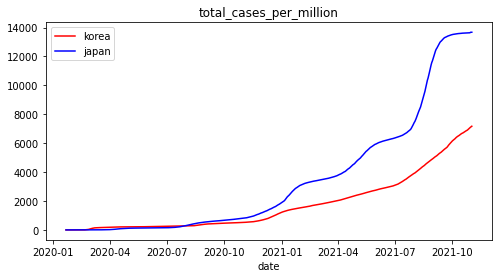

In [ ]:
# Task 2-1. 날짜별 확진자 비율 시각화

plt.figure(figsize=(8,4))
plt.plot(korea['date'], korea['total_cases_per_million'], 'r', label = 'korea')
plt.plot(japan['date'], japan['total_cases_per_million'], 'b', label = 'japan')

plt.legend()
plt.xlabel('date')
plt.title('total_cases_per_million')

plt.show()

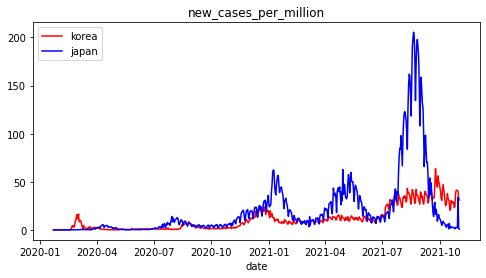

In [ ]:
# Task 2-2. 날짜별 신규 확진자 비율 시각화

plt.figure(figsize=(8,4))
plt.plot(korea['date'], korea['new_cases_per_million'], 'r', label = 'korea')
plt.plot(japan['date'], japan['new_cases_per_million'], 'b', label = 'japan')

plt.legend()
plt.xlabel('date')
plt.title('new_cases_per_million')

plt.show()

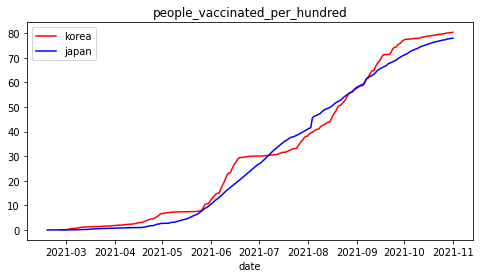

In [ ]:
# Task 2-3. 날짜별 백신 접종자 비율 시각화

plt.figure(figsize=(8,4))
plt.plot(korea['date'], korea['people_vaccinated_per_hundred'], 'r', label = 'korea')
japan2_3 = japan[['date', 'people_vaccinated_per_hundred']].dropna() # 결측치 제거
plt.plot(japan2_3['date'], japan2_3['people_vaccinated_per_hundred'], 'b', label = 'japan')

plt.legend()
plt.xlabel('date')
plt.title('people_vaccinated_per_hundred')

plt.show()

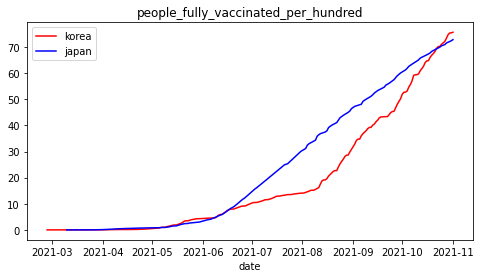

In [ ]:
# Task 2-4. 날짜별 백신 접종 완료자 비율 시각화

plt.figure(figsize=(8,4))
plt.plot(korea['date'], korea['people_fully_vaccinated_per_hundred'], 'r', label = 'korea')
japan2_4 = japan[['date', 'people_fully_vaccinated_per_hundred']].dropna() # 결측치 제거
plt.plot(japan2_4['date'], japan2_4['people_fully_vaccinated_per_hundred'], 'b', label = 'japan')

plt.legend()
plt.xlabel('date')
plt.title('people_fully_vaccinated_per_hundred')

plt.show()

# Task 3. 백신 접종률과 확진자 비율 대비 사망자 비율 사이의 상관관계 알아보기

In [ ]:
# Task 3-1  데이터에서 다음의 열만 남긴 새로운 데이터프레임 생성하기

data3 = data1[['location', 'date', 'total_deaths_per_million', 'total_cases_per_million', 'people_vaccinated_per_hundred', 'human_development_index']].dropna()

In [ ]:
# Task 3-2 각 국가별로 가장 최근 날짜의 데이터 추출하기

data3_2 = data3.loc[data3.groupby(['location'])['date'].idxmax()]

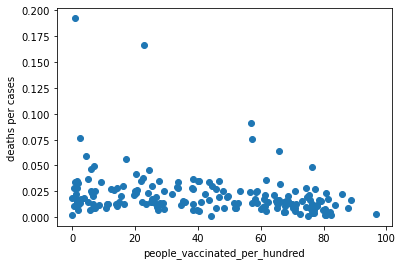

In [ ]:
# Task 3-3 백신 접종률을 x축, 확진자 비율 대비 사망자 비율을 y축으로하는 scatter plot그리기

plt.scatter(data3_2['people_vaccinated_per_hundred'], data3_2['total_deaths_per_million']/data3_2['total_cases_per_million'])

plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('deaths per cases')

plt.show()


In [ ]:
# Task 3-4  백신 접종률과 확진자 비율 대비 사망자 비율 사이의 상관계수(Pearson Correlation Coefficient) 구하기

def pearson_similarity(a, b):
    a = a - a.mean()
    b = b - b.mean()
    nom = np.sum(a * b)
    denom = np.sqrt(np.sum(a ** 2)) * np.sqrt(np.sum(b ** 2))
    if denom != 0:
        return nom/denom
    else:
        return 0

vaccinated = data3_2['people_vaccinated_per_hundred']
death_by_cases = data3_2['total_deaths_per_million']/data3_2['total_cases_per_million']

pearson_similarity(vaccinated, death_by_cases)

-0.2516905626105017

# Task 4. HDI 계수 와 백신 접종률 사이의 상관관계 알아보기

In [ ]:
# Task 4-1 HDI 계수와 백신 접종률 사이의 상관계수 (Pearson Correlation Coefficient) 구하기

data4 = data3_2[['location','human_development_index', 'people_vaccinated_per_hundred']].dropna() # 결측치 제거
hdi = data4['human_development_index']
vaccinated = data4['people_vaccinated_per_hundred']

pearson_similarity(hdi, vaccinated)

0.8223528627985828

In [ ]:
# Task 4-2 Linear Regression 방법으로 HDI 계수와 백신 접종률 사이의 선형 관계 학습하기 

x = torch.tensor([x for x in hdi]).reshape(-1,1)
y = torch.tensor([y for y in vaccinated]).reshape(-1, 1)

W = torch.zeros(1,1)
b = torch.zeros(1,1)

optimizer = torch.optim.SGD([W,b], lr=0.1)

for epoch in range(3001):
    W.requires_grad_(True)
    b.requires_grad_(True)

    hypothesis = torch.mm(x, W) + b
    cost = torch.mean((hypothesis - y) ** 2)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

print( f'W: {W.squeeze():.6f}, b: {b.squeeze():.6f}')

W: 150.301132, b: -66.839813


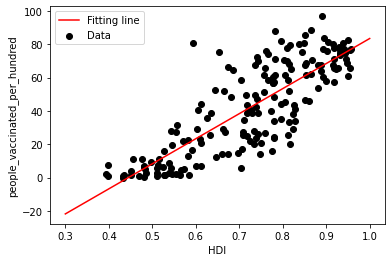

In [ ]:
# Task 4-3 HDI 계수를 x축으로, 백신 접종률을 y축으로하는 scatter plot과, Task 4-2에서 학습한 직선을 겹쳐 그리기

W.requires_grad_(False)
b.requires_grad_(False)

plt.scatter(x, y, c="black", label="Data")

X = torch.linspace(0.3,1,100).unsqueeze(1)
Y = torch.mm(X,W)+b
plt.plot(X,Y, c="#ff0000", label="Fitting line")

plt.xlabel("HDI")
plt.ylabel('people_vaccinated_per_hundred')
plt.legend()

plt.show()